# Importar librerías + data

In [126]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers, models, utils, regularizers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import stats


In [127]:
# Load data from parquet file
data = (
    pl.scan_parquet('datasets/teams/battlelog_train.parquet')
    ).collect()

data.columns

['event_mode',
 'event_map',
 'battle_team1_player1_brawler_name',
 'battle_team1_player2_brawler_name',
 'battle_team1_player3_brawler_name',
 'battle_team2_player1_brawler_name',
 'battle_team2_player2_brawler_name',
 'battle_team2_player3_brawler_name',
 'battle_team1_player1_brawler_Class',
 'battle_team1_player2_brawler_Class',
 'battle_team1_player3_brawler_Class',
 'battle_team2_player1_brawler_Class',
 'battle_team2_player2_brawler_Class',
 'battle_team2_player3_brawler_Class',
 'battle_team1_player1_brawler_Role',
 'battle_team1_player2_brawler_Role',
 'battle_team1_player3_brawler_Role',
 'battle_team2_player1_brawler_Role',
 'battle_team2_player2_brawler_Role',
 'battle_team2_player3_brawler_Role',
 'battle_team1_player1_brawler_Movement_Speed',
 'battle_team1_player2_brawler_Movement_Speed',
 'battle_team1_player3_brawler_Movement_Speed',
 'battle_team2_player1_brawler_Movement_Speed',
 'battle_team2_player2_brawler_Movement_Speed',
 'battle_team2_player3_brawler_Movement_S

Limpiar categorías

In [128]:
# reemplazar valor "Clyde; Slow" por "Slow" en cada columna Movement_Speed
data = data.with_columns(pl.col('battle_team1_player1_brawler_Movement_Speed').str.replace('Clyde; Slow', 'Slow'))
data = data.with_columns(pl.col('battle_team1_player2_brawler_Movement_Speed').str.replace('Clyde; Slow', 'Slow'))
data = data.with_columns(pl.col('battle_team1_player3_brawler_Movement_Speed').str.replace('Clyde; Slow', 'Slow'))
data = data.with_columns(pl.col('battle_team2_player1_brawler_Movement_Speed').str.replace('Clyde; Slow', 'Slow'))
data = data.with_columns(pl.col('battle_team2_player2_brawler_Movement_Speed').str.replace('Clyde; Slow', 'Slow'))
data = data.with_columns(pl.col('battle_team2_player3_brawler_Movement_Speed').str.replace('Clyde; Slow', 'Slow'))

In [129]:
def one_hot_encoding(df, col, prefix):
	"""
	Función para convertir las etiquetas de texto a valores numéricos
	y luego convertir los valores numéricos a "one-hot encoding"
	"""	

	y = df[col]
	x = df.drop([col])

	le = LabelEncoder()
	y = le.fit_transform(y)

	# Convertir los valores numéricos a "one-hot encoding"
	y = pl.DataFrame(utils.to_categorical(y))

	y = y.select([pl.col('column_' + str(i)).alias(prefix + '_' + item) for i, item in enumerate(le.classes_)])
	
	# unir el dataframe con las categorias codificadas
	df_encoded = pl.concat([x, y], how='horizontal')

	return df_encoded

cols = [
	['event_mode', 'EM'],
	['event_map', 'MP'],
	# ['battle_team1_player1_brawler_name', 'T1B1'],
	# ['battle_team1_player2_brawler_name', 'T1B2'],
	# ['battle_team1_player3_brawler_name', 'T1B3'],
	# ['battle_team2_player1_brawler_name', 'T2B1'],
	# ['battle_team2_player2_brawler_name', 'T2B2'],
	# ['battle_team2_player3_brawler_name', 'T2B3'],
	# ['battle_team1_player1_brawler_Class', 'T1C1'],
	# ['battle_team1_player2_brawler_Class', 'T1C2'],
	# ['battle_team1_player3_brawler_Class',	'T1C3'],
	# ['battle_team2_player1_brawler_Class', 'T2C1'],
	# ['battle_team2_player2_brawler_Class', 'T2C2'],
	# ['battle_team2_player3_brawler_Class', 'T2C3'],
	# ['battle_team1_player1_brawler_Role',	'T1R1'],
	# ['battle_team1_player2_brawler_Role',	'T1R2'],
	# ['battle_team1_player3_brawler_Role',	'T1R3'],
	# ['battle_team2_player1_brawler_Role',	'T2R1'],
	# ['battle_team2_player2_brawler_Role',	'T2R2'],
	# ['battle_team2_player3_brawler_Role',	'T2R3'],
	['battle_team1_player1_brawler_Movement_Speed', 'T1S1'],
	['battle_team1_player2_brawler_Movement_Speed', 'T1S2'],
	['battle_team1_player3_brawler_Movement_Speed', 'T1S3'],
	['battle_team2_player1_brawler_Movement_Speed', 'T2S1'],
	['battle_team2_player2_brawler_Movement_Speed', 'T2S2'],
	['battle_team2_player3_brawler_Movement_Speed', 'T2S3'],
	['battle_team1_player1_brawler_Range', 'T1G1'],
	['battle_team1_player2_brawler_Range', 'T1G2'],
	['battle_team1_player3_brawler_Range', 'T1G3'],
	['battle_team2_player1_brawler_Range', 'T2G1'],
	['battle_team2_player2_brawler_Range', 'T2G2'],
	['battle_team2_player3_brawler_Range',	'T2G3'],
]

for col in cols:
	data = one_hot_encoding(data, col[0], col[1])

data.columns

['battle_team1_player1_brawler_name',
 'battle_team1_player2_brawler_name',
 'battle_team1_player3_brawler_name',
 'battle_team2_player1_brawler_name',
 'battle_team2_player2_brawler_name',
 'battle_team2_player3_brawler_name',
 'battle_team1_player1_brawler_Class',
 'battle_team1_player2_brawler_Class',
 'battle_team1_player3_brawler_Class',
 'battle_team2_player1_brawler_Class',
 'battle_team2_player2_brawler_Class',
 'battle_team2_player3_brawler_Class',
 'battle_team1_player1_brawler_Role',
 'battle_team1_player2_brawler_Role',
 'battle_team1_player3_brawler_Role',
 'battle_team2_player1_brawler_Role',
 'battle_team2_player2_brawler_Role',
 'battle_team2_player3_brawler_Role',
 'winner_team',
 'barriers',
 'barriers_center',
 'bushes',
 'bushes_center',
 'waterProp',
 'avg_brawler_Range_Num_team1',
 'avg_brawler_Range_Num_team2',
 'avg_brawler_trophies_team1',
 'avg_brawler_trophies_team2',
 'avg_brawler_Health_team1',
 'avg_brawler_Health_team2',
 'avg_brawler_Speed_Num_team1',
 '

In [130]:
# corregir valores columna winner_team restándole 1

data = data.with_columns(pl.col('winner_team') - 1)

data['winner_team'].value_counts()

winner_team,counts
i8,u32
0,270913
1,273158


In [131]:
# eliminar columnas redundantes

data = data.drop(
    [
    'battle_team1_player1_brawler_Class',
    'battle_team1_player2_brawler_Class',
    'battle_team1_player3_brawler_Class',
    'battle_team2_player1_brawler_Class',
    'battle_team2_player2_brawler_Class',
    'battle_team2_player3_brawler_Class',
    'battle_team1_player1_brawler_Role',
    'battle_team1_player2_brawler_Role',
    'battle_team1_player3_brawler_Role',
    'battle_team2_player1_brawler_Role',
    'battle_team2_player2_brawler_Role',
    'battle_team2_player3_brawler_Role',
    'battle_team1_player1_brawler_name',
    'battle_team1_player2_brawler_name',
    'battle_team1_player3_brawler_name',
    'battle_team2_player1_brawler_name',
    'battle_team2_player2_brawler_name',
    'battle_team2_player3_brawler_name',
    'barriers',
    'barriers_center',
    'bushes',
    'bushes_center',
    'waterProp',
    'avg_brawler_Range_Num_team1',
    'avg_brawler_Range_Num_team2',
    'avg_brawler_trophies_team1',
    'avg_brawler_trophies_team2',
    'avg_brawler_Health_team1',
    'avg_brawler_Health_team2',
    'avg_brawler_Speed_Num_team1',
    'avg_brawler_Speed_Num_team2',
    'avg_brawler_winrate_team1',
    'avg_brawler_winrate_team2',
    'avg_brawler_winrate_overall_team1',
    'avg_brawler_winrate_overall_team2',
    'avg_highestTrophies_team1',
    'avg_highestTrophies_team2',
    'avg_trophies_team1',
    'avg_trophies_team2',
    'avg_expPoints_team1',
    'avg_expPoints_team2',
    'avg_team_victories_team1',
    'avg_team_victories_team2',
    'max_brawler_Range_Num_team1',
    'max_brawler_Range_Num_team2',
    'max_brawler_trophies_team1',
    'max_brawler_trophies_team2',
    'max_brawler_Health_team1',
    'max_brawler_Health_team2',
    'max_brawler_Speed_Num_team1',
    'max_brawler_Speed_Num_team2',
    'max_brawler_winrate_team1',
    'max_brawler_winrate_team2',
    'max_brawler_winrate_overall_team1',
    'max_brawler_winrate_overall_team2',
    'max_highestTrophies_team1',
    'max_highestTrophies_team2',
    'max_trophies_team1',
    'max_trophies_team2',
    'max_expPoints_team1',
    'max_expPoints_team2',
    'max_team_victories_team1',
    'max_team_victories_team2',
    'min_brawler_Range_Num_team1',
    'min_brawler_Range_Num_team2',
    'min_brawler_trophies_team1',
    'min_brawler_trophies_team2',
    'min_brawler_Health_team1',
    'min_brawler_Health_team2',
    'min_brawler_Speed_Num_team1',
    'min_brawler_Speed_Num_team2',
    'min_brawler_winrate_team1',
    'min_brawler_winrate_team2',
    'min_brawler_winrate_overall_team1',
    'min_brawler_winrate_overall_team2',
    'min_highestTrophies_team1',
    'min_highestTrophies_team2',
    'min_trophies_team1',
    'min_trophies_team2',
    'min_expPoints_team1',
    'min_expPoints_team2',
    'min_team_victories_team1',
    'min_team_victories_team2',
    'battle_power_team1',
    'battle_power_team2',
    ]
)

In [132]:
data.columns

['winner_team',
 'avg_brawler_Range_Num_diff',
 'avg_brawler_trophies_diff',
 'avg_brawler_Health_diff',
 'avg_brawler_Speed_Num_diff',
 'avg_brawler_winrate_diff',
 'avg_brawler_winrate_overall_diff',
 'avg_highestTrophies_diff',
 'avg_trophies_diff',
 'avg_expPoints_diff',
 'avg_team_victories_diff',
 'max_brawler_Range_Num_diff',
 'max_brawler_trophies_diff',
 'max_brawler_Health_diff',
 'max_brawler_Speed_Num_diff',
 'max_brawler_winrate_diff',
 'max_brawler_winrate_overall_diff',
 'max_highestTrophies_diff',
 'max_trophies_diff',
 'max_expPoints_diff',
 'max_team_victories_diff',
 'min_brawler_Range_Num_diff',
 'min_brawler_trophies_diff',
 'min_brawler_Health_diff',
 'min_brawler_Speed_Num_diff',
 'min_brawler_winrate_diff',
 'min_brawler_winrate_overall_diff',
 'min_highestTrophies_diff',
 'min_trophies_diff',
 'min_expPoints_diff',
 'min_team_victories_diff',
 'battle_power_diff',
 'EM_bounty',
 'EM_brawlBall',
 'EM_gemGrab',
 'EM_heist',
 'EM_hotZone',
 'EM_knockout',
 'MP_Bac

Generar test split

In [133]:
seed=14693

data = data.to_pandas()

train, test = train_test_split(data, test_size = 0.7, random_state=seed)

train = pd.DataFrame(train)
test = pd.DataFrame(test)

print(str(train.shape) + " train samples")
print(str(test.shape) + " test samples")

(163221, 134) train samples
(380850, 134) test samples


# Entrenando y comparando diferentes Modelos

In [165]:
# Definición de funciones

optimizer = optimizers.Adam(learning_rate=0.001)
loss = 'binary_crossentropy' # ideal para clasificación binaria
metrics = ['accuracy', 'Precision', 'Recall', 'FalseNegatives', 'FalsePositives', 'TrueNegatives', 'TruePositives']

def compile_model(model):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

def compile_train_models(model, train, test, epochs=25, verbose=2, batch_size=512):
	print('Iniciando entrenamiento de modelo: ' + str(model.name))
	compile_model(model)
	historial = model.fit(train.drop(['winner_team'], axis=1), train['winner_team'], epochs=epochs, verbose=verbose, batch_size=batch_size, validation_data=(test.drop(['winner_team'], axis=1), test['winner_team']))
	return historial

def linear_extrapolation(values, x_new):
    x = np.arange(len(values))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, values)
    y_new = slope * x_new + intercept
    return y_new

In [145]:
input_dim = len(train.columns) - 1
input_dim

133

In [159]:
model_0 = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_0.summary()


Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_55 (Conv1D)          (None, 131, 32)           128       
                                                                 
 flatten_23 (Flatten)        (None, 4192)              0         
                                                                 
 dense_136 (Dense)           (None, 64)                268352    
                                                                 
 dense_137 (Dense)           (None, 64)                4160      
                                                                 
 dense_138 (Dense)           (None, 1)                 65        
                                                                 
Total params: 272,705
Trainable params: 272,705
Non-trainable params: 0
_________________________________________________________________


In [160]:
model_1 = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(input_dim, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model_1.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_56 (Conv1D)          (None, 131, 64)           256       
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 65, 64)           0         
 g1D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 4160)              0         
                                                                 
 dense_139 (Dense)           (None, 64)                266304    
                                                                 
 dense_140 (Dense)           (None, 1)                 65        
                                                                 
Total params: 266,625
Trainable params: 266,625
Non-trainable params: 0
_______________________________________________

In [161]:
model_2 = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(input_dim, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

model_2.summary()


Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_57 (Conv1D)          (None, 131, 64)           256       
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 65, 64)           0         
 g1D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 65, 64)            0         
                                                                 
 flatten_25 (Flatten)        (None, 4160)              0         
                                                                 
 dense_141 (Dense)           (None, 64)                266304    
                                                                 
 dropout_51 (Dropout)        (None, 64)                0         
                                                     

In [162]:
model_3 = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(input_dim, 1)),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

model_3.summary()


Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_58 (Conv1D)          (None, 131, 32)           128       
                                                                 
 conv1d_59 (Conv1D)          (None, 129, 32)           3104      
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 64, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_60 (Conv1D)          (None, 62, 64)            6208      
                                                                 
 conv1d_61 (Conv1D)          (None, 60, 64)            12352     
                                                                 
 max_pooling1d_37 (MaxPoolin  (None, 30, 64)           0         
 g1D)                                                

In [163]:
model_list = [model_0, model_1, model_2, model_3]

history_dict = {}
for model in model_list:
	trained_models = compile_train_models(model, train, test, verbose=1)
	history_dict['model_' + str(model.name)] = trained_models.history

Iniciando entrenamiento de modelo: sequential_49
Epoch 1/25
319/319 [==============================] - 21s 61ms/step - loss: 0.5756 - accuracy: 0.6892 - precision: 0.6907 - recall: 0.6908 - false_negatives: 25351.0000 - false_positives: 25373.0000 - true_negatives: 55848.0000 - true_positives: 56649.0000 - val_loss: 0.5672 - val_accuracy: 0.6963 - val_precision: 0.6940 - val_recall: 0.7065 - val_false_negatives: 56096.0000 - val_false_positives: 59551.0000 - val_true_negatives: 130141.0000 - val_true_positives: 135062.0000
Epoch 2/25
319/319 [==============================] - 18s 58ms/step - loss: 0.5652 - accuracy: 0.6971 - precision: 0.6990 - recall: 0.6976 - false_negatives: 24797.0000 - false_positives: 24637.0000 - true_negatives: 56584.0000 - true_positives: 57203.0000 - val_loss: 0.5652 - val_accuracy: 0.6967 - val_precision: 0.6944 - val_recall: 0.7070 - val_false_negatives: 56012.0000 - val_false_positives: 59486.0000 - val_true_negatives: 130206.0000 - val_true_positives: 135

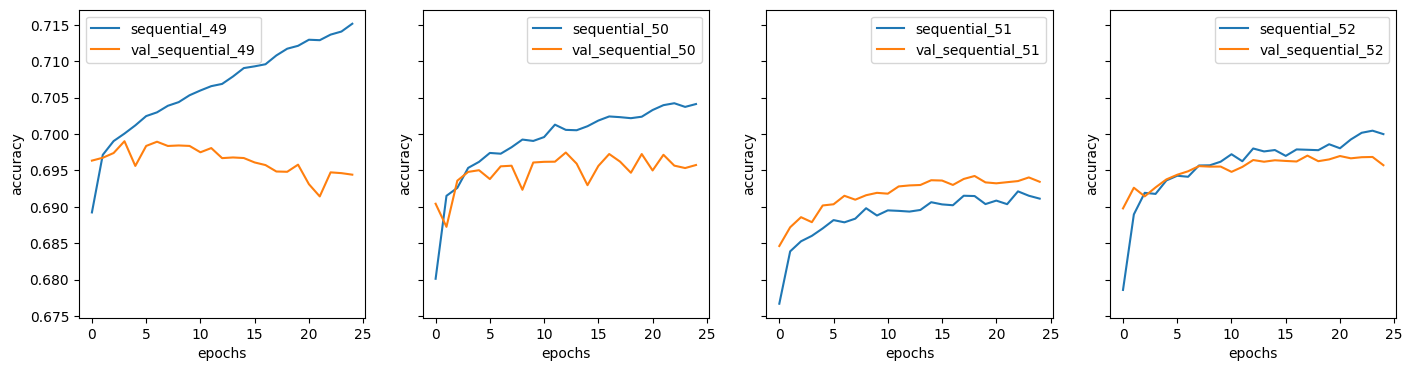

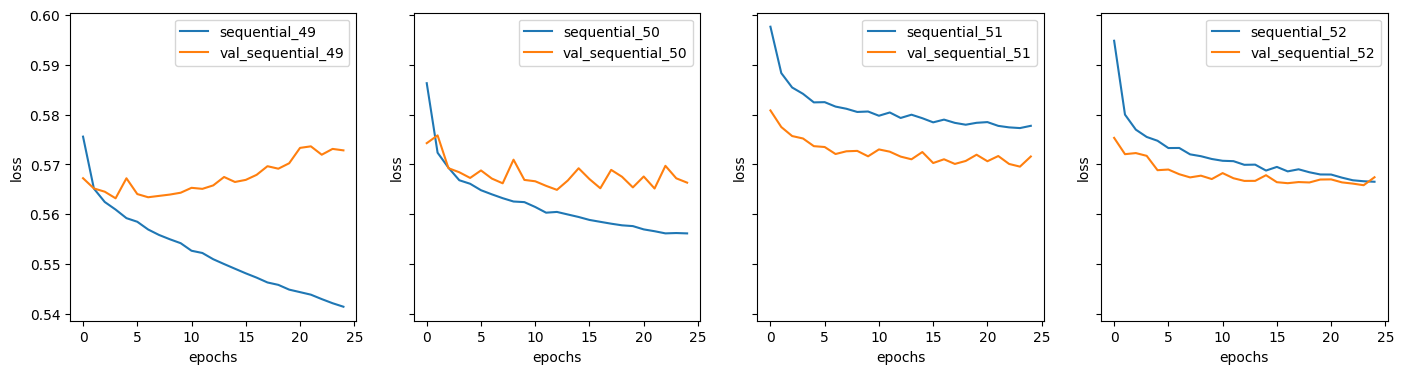

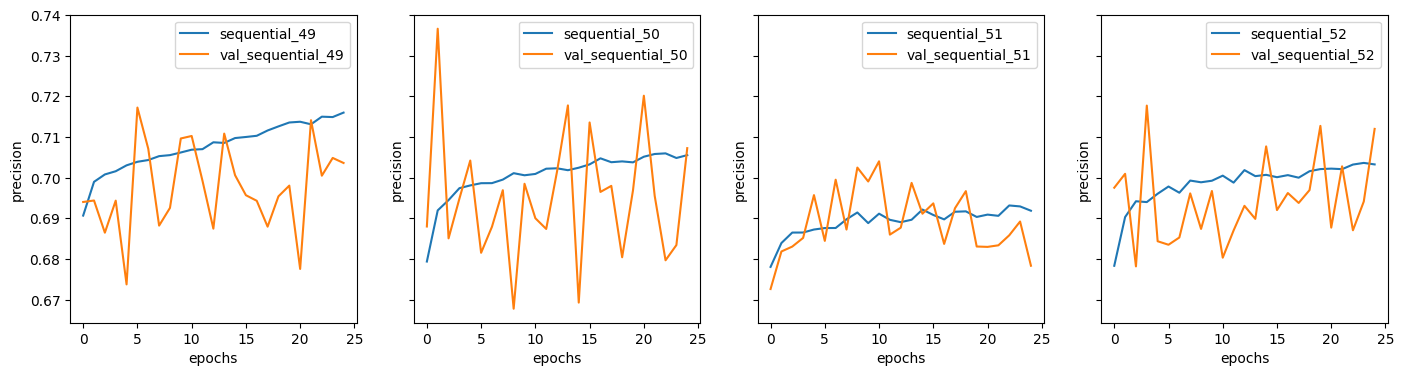

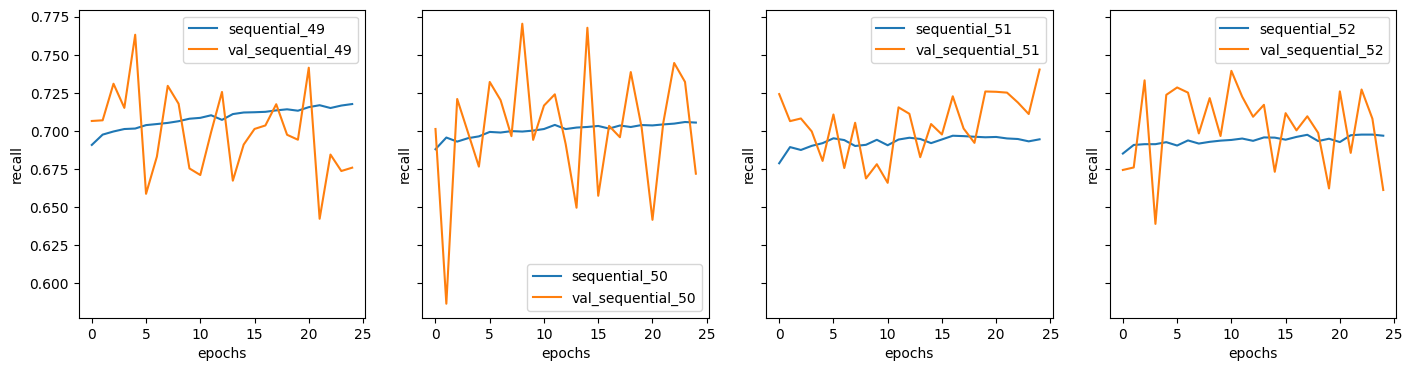

In [164]:
# Plot training & model comparison
# x_new = [25:30]
# y_new = linear_extrapolation(history_dict['model_' + str(model.name)], x_new)

graph_list = ['accuracy', 'loss', 'precision', 'recall']

for graph in graph_list:
	fig, ax = plt.subplots(1, len(model_list), sharex=True, sharey=True, figsize=(17, 4))
	for i, model in enumerate(model_list):
		ax[i].plot(history_dict['model_' + str(model.name)][graph], label=model.name)
		ax[i].plot(history_dict['model_' + str(model.name)]['val_' + graph], label='val_' + model.name)
		ax[i].set_xlabel("epochs")
		ax[i].set_ylabel(graph)
		ax[i].legend()
	plt.savefig('plots/cnn/model_comparison_' + graph + '.png')
	plt.show()

el modelo escogido es el que muestra mejor proyección en las epochs, se procede a entrenarlo en un ciclo más grande

## Selecion of Batchsize

In [168]:
batch_size_list = [256, 512, 1024]

history_dict = {}
for batch_size in batch_size_list:
	trained_models = compile_train_models(model_2, train, test, epochs=10, batch_size=batch_size)
	history_dict['batch_size_' + str(batch_size)] = trained_models.history

Iniciando entrenamiento de modelo: sequential_51
Epoch 1/10
638/638 - 57s - loss: 0.5777 - accuracy: 0.6912 - precision: 0.6909 - recall: 0.6970 - false_negatives: 24842.0000 - false_positives: 25566.0000 - true_negatives: 55655.0000 - true_positives: 57158.0000 - val_loss: 0.5689 - val_accuracy: 0.6943 - val_precision: 0.6830 - val_recall: 0.7293 - val_false_negatives: 51748.0000 - val_false_positives: 64693.0000 - val_true_negatives: 124999.0000 - val_true_positives: 139410.0000 - 57s/epoch - 89ms/step
Epoch 2/10
638/638 - 45s - loss: 0.5775 - accuracy: 0.6922 - precision: 0.6939 - recall: 0.6929 - false_negatives: 25180.0000 - false_positives: 25060.0000 - true_negatives: 56161.0000 - true_positives: 56820.0000 - val_loss: 0.5711 - val_accuracy: 0.6946 - val_precision: 0.7041 - val_recall: 0.6755 - val_false_negatives: 62034.0000 - val_false_positives: 54270.0000 - val_true_negatives: 135422.0000 - val_true_positives: 129124.0000 - 45s/epoch - 71ms/step
Epoch 3/10
638/638 - 49s - lo

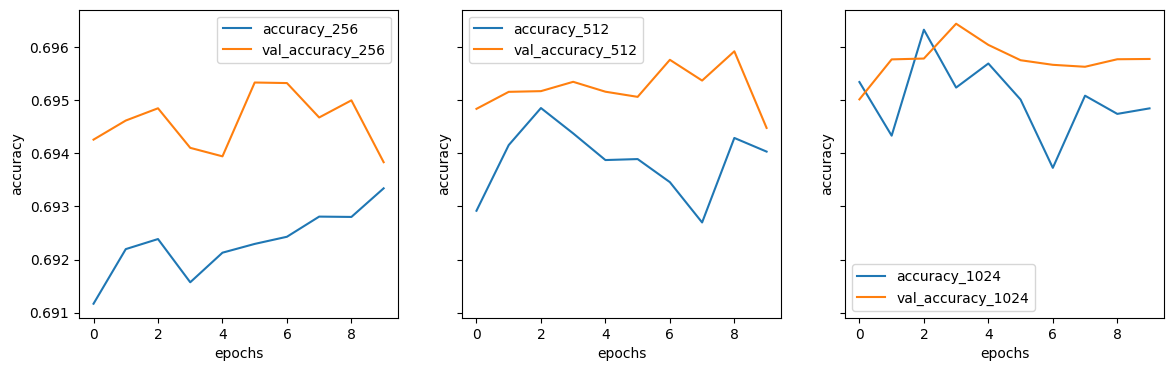

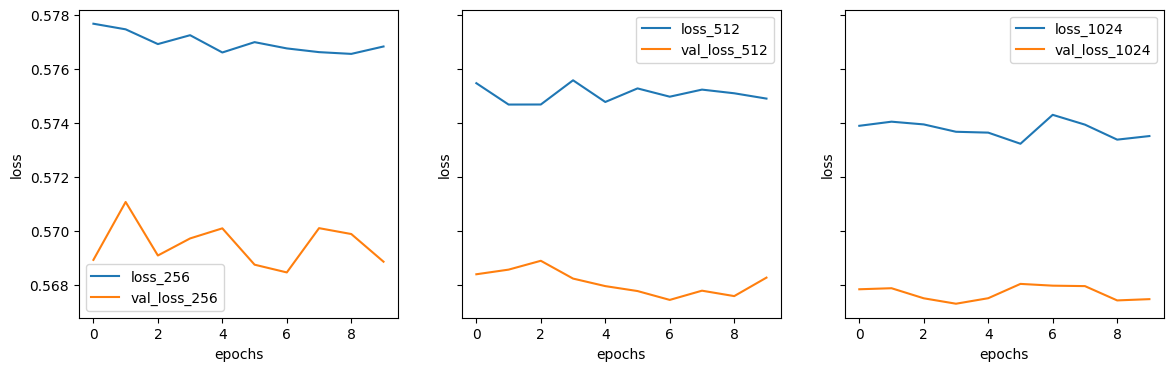

In [169]:
graph_list = ['accuracy', 'loss']

for graph in graph_list:
	fig, ax = plt.subplots(1, len(batch_size_list), sharex=True, sharey=True, figsize=(14, 4))
	for i, batch_size in enumerate(batch_size_list):
		ax[i].plot(history_dict['batch_size_' + str(batch_size)][graph], label=graph + '_' + str(batch_size))
		ax[i].plot(history_dict['batch_size_' + str(batch_size)]['val_' + graph], label='val_' + graph + '_' + str(batch_size))
		ax[i].set_xlabel("epochs")
		ax[i].set_ylabel(graph)
		ax[i].legend()
	plt.savefig('plots/cnn/batch_comparison_' + graph + '_' + str(batch_size) + '.png')
	plt.show()

Es más conveniente utilizar batch_size = 1024 para aprovechar la memoria disponible y conservar la eficiencia

In [170]:
# se procede a entrenar a 100 epochs
result = compile_train_models(model_2, train, test, epochs=100, verbose=2, batch_size=1024)

Iniciando entrenamiento de modelo: sequential_51
Epoch 1/100
160/160 - 47s - loss: 0.5742 - accuracy: 0.6942 - precision: 0.6949 - recall: 0.6975 - false_negatives: 24801.0000 - false_positives: 25115.0000 - true_negatives: 56106.0000 - true_positives: 57199.0000 - val_loss: 0.5681 - val_accuracy: 0.6957 - val_precision: 0.6897 - val_recall: 0.7157 - val_false_negatives: 54338.0000 - val_false_positives: 61558.0000 - val_true_negatives: 128134.0000 - val_true_positives: 136820.0000 - 47s/epoch - 293ms/step
Epoch 2/100
160/160 - 41s - loss: 0.5742 - accuracy: 0.6943 - precision: 0.6949 - recall: 0.6979 - false_negatives: 24774.0000 - false_positives: 25130.0000 - true_negatives: 56091.0000 - true_positives: 57226.0000 - val_loss: 0.5676 - val_accuracy: 0.6960 - val_precision: 0.6940 - val_recall: 0.7053 - val_false_negatives: 56341.0000 - val_false_positives: 59437.0000 - val_true_negatives: 130255.0000 - val_true_positives: 134817.0000 - 41s/epoch - 256ms/step
Epoch 3/100
160/160 - 46s

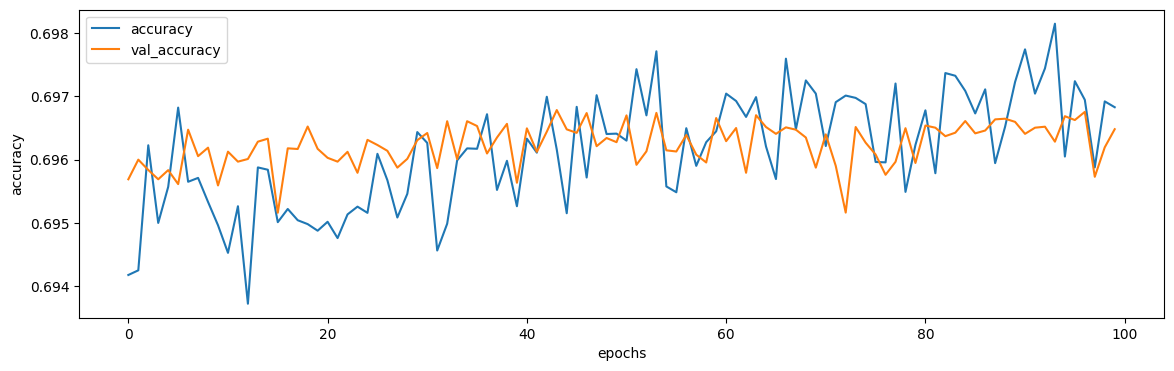

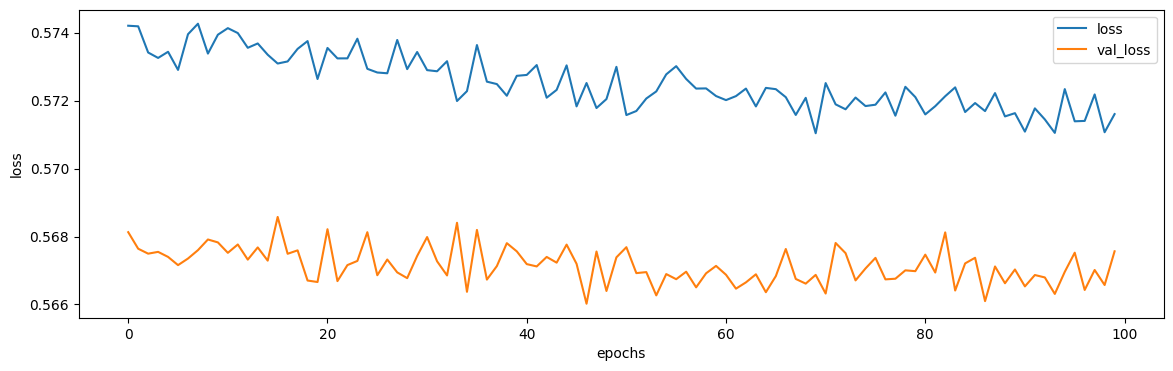

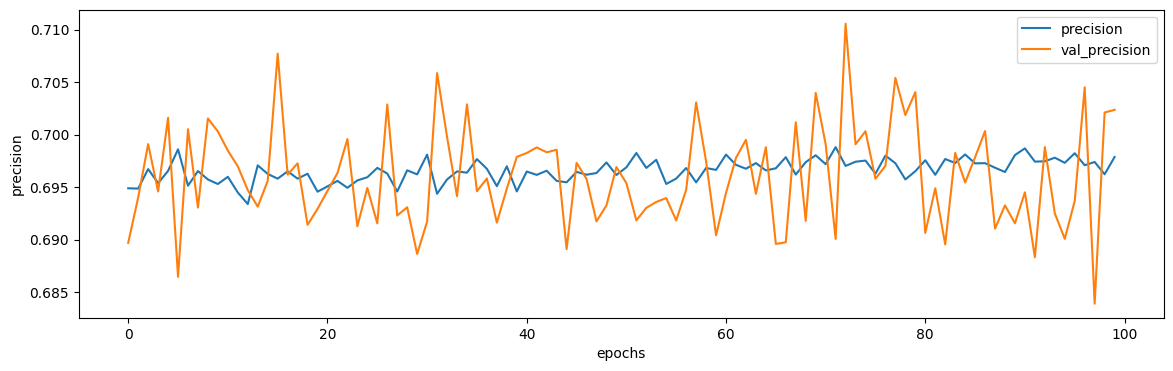

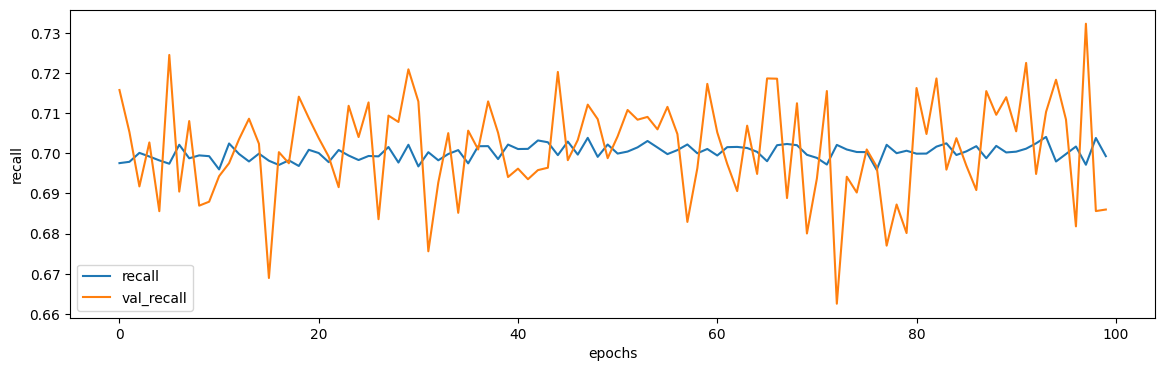

In [175]:
# Plot training & model comparison

graph_list = ['accuracy', 'loss', 'precision', 'recall']

for graph in graph_list:
	fig, ax = plt.subplots(figsize=(14, 4))
	ax.plot(result.history[graph], label=graph)
	ax.plot(result.history['val_' + graph], label='val_' + graph)
	ax.set_xlabel("epochs")
	ax.set_ylabel(graph)
	ax.legend()
	plt.savefig('plots/cnn/final_model_' + graph + '.png')
	plt.show()

In [14]:
# test['prediction'] = model_1.predict(test.drop(['winner'], axis=1))
# test['prediction_result'] = test['prediction'].apply(lambda x: True if x > 0.5 else False).astype(bool)

# def get_metrics(test):
# 	true_positives = test[(test['winner'] == True) & (test['winner'] == test['prediction_result'])].shape[0]
# 	true_negatives = test[(test['winner'] == False) & (test['winner'] == test['prediction_result'])].shape[0]
# 	false_positives = test[(test['winner'] == False) & (test['winner'] != test['prediction_result'])].shape[0]
# 	false_negatives = test[(test['winner'] == True) & (test['winner'] != test['prediction_result'])].shape[0]
# 	return true_positives, true_negatives, false_positives, false_negatives

# true_positives_test, true_negatives_test, false_positives_test, false_negatives_test = get_metrics(test)

In [176]:
false_positives_train = result.history['false_positives'][-1]
false_negatives_train = result.history['false_negatives'][-1]
true_positives_train = result.history['true_positives'][-1]
true_negatives_train = result.history['true_negatives'][-1]
f1_score_train = 2 * (true_positives_train / (2 * true_positives_train + false_positives_train + false_negatives_train))
accuracy_train = (true_positives_train + true_negatives_train) / (true_positives_train + true_negatives_train + false_positives_train + false_negatives_train)

print('F1 Score Train: ' + str(f1_score_train))
print('Accuracy Train: ' + str(accuracy_train))

F1 Score Train: 0.6985733952219095
Accuracy Train: 0.696828226760037


In [177]:
evaluate_test = model_2.evaluate(test.drop(['winner_team'], axis=1), np.asarray(test['winner_team']).astype(np.float32), batch_size=512)
false_negatives_test = evaluate_test[4]
false_positives_test = evaluate_test[5]
true_negatives_test = evaluate_test[6]
true_positives_test = evaluate_test[7]

f1_score_test = 2 * (true_positives_test / (2 * true_positives_test + false_positives_test + false_negatives_test))
accuracy_test = (true_positives_test + true_negatives_test) / (true_positives_test + true_negatives_test + false_positives_test + false_negatives_test)

print('F1 Score Test: ' + str(f1_score_test))
print('Accuracy Test: ' + str(accuracy_test))

744/744 [==============================] - 16s 21ms/step - loss: 0.5676 - accuracy: 0.6965 - precision: 0.7024 - recall: 0.6860 - false_negatives: 60023.0000 - false_positives: 55572.0000 - true_negatives: 134120.0000 - true_positives: 131135.0000
F1 Score Test: 0.6940838659309542
Accuracy Test: 0.6964815544177497


In [178]:
# Guardar el Modelo
model.save('models/cnn_model_finalized.h5')